<a href="https://colab.research.google.com/github/Manerrando28/gs-futuro-do-trabalho-2025-/blob/main/GS_DnyamicProgramy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Solution 2025 - Dynamic Programming aplicada ao Futuro do Trabalho

# Disciplina: Dynamic Programming
# Professor: André Marques

Integrante:

Nome: Gabriel Guilherme Leste

RM: 558638

# DESAFIO 1 — Otimização 2D com Programação Dinâmica + Monte Carlo (1000 cenários)
Introdução Acadêmica do Desafio

Este desafio modela a seleção de trilhas de capacitação como um Knapsack multidimensional (NP-hard) com duas restrições simultâneas: Tempo total (T) e Complexidade total (C). Utilizamos Programação Dinâmica 2D (DP 2D) para construir uma tabela de estados dp[T][C] que guarda o máximo Valor atingível para cada par (T, C), produzindo uma solução ótima para o domínio finito considerado.
Como o Valor percebido das habilidades pode variar no mundo real (mudanças tecnológicas e de demanda), incorporamos incerteza via simulação de Monte Carlo (1000 cenários com
𝑉
∼
U
n
i
f
o
r
m
(
𝑉
⋅
(
1
−
0,10
)
,

𝑉
⋅
(
1
+
0,10
)
)
V∼Uniform(V⋅(1−0,10), V⋅(1+0,10))). Relatamos o valor esperado
𝐸
[
Valor
]
E[Valor], o desvio-padrão e comparamos com a solução determinística (sem ruído).

# Dados e Helpers (auto-contido)


In [3]:
# ---------------------------------------------------------
# PRÉ-BLOCO: dataset mínimo e helper de pré-requisitos
# (só cria se ainda não existir no notebook)
# ---------------------------------------------------------
from typing import Dict, List, Tuple
import random, statistics

if "skills" not in globals():
    RAW_SKILLS = [
        ("S1","Programação Básica (Python)", 80, 3, 4,  ""),
        ("S2","Modelagem de Dados (SQL)",    60, 4, 3,  ""),
        ("S3","Algoritmos Avançados",       100, 7, 8,  "S1"),
        ("S4","Fund. de Machine Learning",  120, 8, 9,  "S1;S3"),
        ("S5","Visualização de Dados (BI)",  40, 6, 5,  "S2"),
        ("S6","IA Generativa Ética",        150,10,10,  "S4"),
        ("S7","Estruturas em Nuvem",         70, 5, 7,  ""),
        ("S8","APIs e Microsserviços",       90, 6, 6,  "S1"),
        ("S9","DevOps & CI/CD",             110, 9, 8,  "S7;S8"),
        ("H10","Segurança de Dados",         60, 5, 6,  ""),
        ("H11","Análise de Big Data",        90, 8, 8,  "S4"),
        ("H12","Introdução a IoT",           30, 3, 3,  ""),
    ]
    skills: Dict[str, Dict[str, int | str]] = {
        sid: {"Nome": nome, "Tempo_h": int(t), "Valor_V": int(v), "Complexidade_C": int(c), "Pre_Reqs": prereq}
        for sid, nome, t, v, c, prereq in RAW_SKILLS
    }

if "parse_prereqs" not in globals():
    def parse_prereqs(prereq_str: str) -> List[str]:
        """'S1;S3' -> ['S1','S3']; [] se vazio."""
        if not isinstance(prereq_str, str) or not prereq_str.strip():
            return []
        return [p.strip() for p in prereq_str.replace(",", ";").split(";") if p.strip()]


# DP 2D (Determinística) + Comparação

Maximiza Valor com T ≤ 350 e C ≤ 30; retorna valor ótimo e conjunto de IDs selecionados.

In [4]:
# ---------------------------------------------------------
# DESAFIO 1 — DP 2D determinística (knapsack Tempo x Complexidade)
# ---------------------------------------------------------
from math import inf

MAX_T, MAX_C = 350, 30  # limites do enunciado

def knapsack_2d(items: List[Tuple[str,int,int,int]],
                max_time: int,
                max_complex: int) -> tuple[float, set]:
    """
    items: [(ID, Tempo_h, Valor_V, Complexidade_C)]
    Saída: (melhor_valor, conjunto_de_IDs_escolhidos)
    Implementação didática: dp[T][C] com 'keep' preservando o conjunto ótimo.
    """
    import numpy as np
    dp = -1e9 * np.ones((max_time+1, max_complex+1), dtype=float)  # -inf prático
    keep = [[set() for _ in range(max_complex+1)] for __ in range(max_time+1)]
    dp[0, 0] = 0.0

    for sid, t, v, c in items:
        new_dp = dp.copy()
        new_keep = [row[:] for row in keep]
        for T in range(max_time + 1):
            for C in range(max_complex + 1):
                if dp[T, C] < 0:
                    continue
                if T + t <= max_time and C + c <= max_complex:
                    cand = dp[T, C] + v
                    if cand > new_dp[T + t, C + c]:
                        new_dp[T + t, C + c] = cand
                        chosen = keep[T][C].copy()
                        chosen.add(sid)
                        new_keep[T + t][C + c] = chosen
        dp, keep = new_dp, new_keep

    best_val = dp.max()
    idx = (dp == best_val).nonzero()
    Tbest, Cbest = int(idx[0][0]), int(idx[1][0])
    return best_val, keep[Tbest][Cbest]

# Executa determinístico
items_base = [(sid, s["Tempo_h"], s["Valor_V"], s["Complexidade_C"]) for sid, s in skills.items()]
best_det, chosen_det = knapsack_2d(items_base, MAX_T, MAX_C)

tot_T = sum(skills[s]["Tempo_h"] for s in chosen_det)
tot_C = sum(skills[s]["Complexidade_C"] for s in chosen_det)

print("DP Determinística — Melhor Valor:", best_det)
print("Selecionadas (IDs):", sorted(chosen_det))
print(f"Tempo total: {tot_T}h | Complexidade total: {tot_C}")


DP Determinística — Melhor Valor: 31.0
Selecionadas (IDs): ['H10', 'H11', 'H12', 'S5', 'S9']
Tempo total: 330h | Complexidade total: 30


# Monte Carlo (1000 cenários, V ~ Uniforme[V±10%])

Maximiza
𝐸
[
Valor
]
E[Valor] e reporta desvio-padrão; compara com o determinístico.

In [5]:
# ---------------------------------------------------------
# DESAFIO 1 — Monte Carlo (1000 cenários, jitter ±10% em Valor_V)
# ---------------------------------------------------------
def monte_carlo_knapsack(items: List[Tuple[str,int,int,int]],
                         n: int = 1000,
                         jitter: float = 0.10,
                         max_time: int = 350,
                         max_complex: int = 30,
                         seed: int = 42) -> tuple[float, float, int]:
    """
    Para cada cenário:
      - Perturba cada Valor_V: V' ~ Uniforme[V*(1-j), V*(1+j)]
      - Resolve a DP 2D e coleta o melhor valor
    Retorna (E[Valor], desvio-padrão populacional, N)
    """
    random.seed(seed)
    resultados = []
    for _ in range(n):
        sampled = []
        for sid, t, v, c in items:
            low, high = max(0, v*(1-jitter)), v*(1+jitter)
            v_s = int(round(random.uniform(low, high)))
            sampled.append((sid, t, v_s, c))
        best_val, _ = knapsack_2d(sampled, max_time, max_complex)
        resultados.append(best_val)

    E = sum(resultados) / len(resultados)
    sd = statistics.pstdev(resultados) if len(resultados) > 1 else 0.0
    return E, sd, len(resultados)

E, sd, N = monte_carlo_knapsack(items_base, n=1000, jitter=0.10, max_time=MAX_T, max_complex=MAX_C, seed=42)

print(f"Monte Carlo — E[Valor]={E:.4f} | desvio-padrão={sd:.4f} | amostras={N}")
print(f"Comparação — Determinístico vs. E[Valor]: {best_det:.4f} vs. {E:.4f}")


Monte Carlo — E[Valor]=31.0110 | desvio-padrão=0.9853 | amostras=1000
Comparação — Determinístico vs. E[Valor]: 31.0000 vs. 31.0110


# Discussão dos Resultados

A DP 2D fornece a solução ótima sob restrições de Tempo e Complexidade, funcionando como um “motor” de alocação de estudos que maximiza valor agregado. A simulação Monte Carlo incorpora variações plausíveis no Valor das habilidades e mostra o quanto a política ótima é robusta: quando
𝐸
[
Valor
]
E[Valor] fica próximo ao resultado determinístico e o desvio-padrão é moderado, concluímos que pequenas oscilações de mercado não alteram substancialmente a qualidade da trilha sugerida. Em cenários com maior incerteza (jitter alto), o E[Valor] tende a “suavizar” extremos e o desvio cresce — informação crucial para a plataforma calibrar nível de confiança e comunicar riscos de variação ao usuário.

# Conclusão Final do Desafio 1

Atendemos integralmente às exigências: modelagem knapsack 2D por DP, execução determinística, simulação Monte Carlo (1000, V±10%), cálculo de
𝐸
[
Valor
]
E[Valor] e desvio-padrão, e comparação com a solução sem ruído. A análise evidencia que a Programação Dinâmica é um alicerce sólido para a plataforma de recomendação de trilhas, enquanto o Monte Carlo adiciona uma camada realista de incerteza, permitindo decisões mais informadas no contexto do Futuro do Trabalho.

# DESAFIO 2 — Verificação Crítica (120 permutações com Pré-requisitos)

Neste desafio tratamos ordenação ótima de 5 Habilidades Críticas (HC = S3, S5, S7, S8, S9) quando há dependências de pré-requisitos. A métrica de custo combina Tempo de Aquisição de cada habilidade + eventual Espera por pré-requisitos ainda não concluídos. Em termos algorítmicos, isso equivale a navegar um DAG (grafo acíclico direcionado) e, para cada ordem candidata, encadear as aquisições exigidas pela restrição de precedência. Enumeramos 5! = 120 permutações (ótimo global por exaustão) e comparamos os 3 menores custos para justificar heurísticas de sequenciamento (por exemplo, “antecipar nós de alta precedência” tende a reduzir interrupções).
Antes de otimizar, validamos o grafo: se houver ciclo (inviabiliza precedência) ou pré-requisito inexistente, interrompemos com mensagem clara — requisito do enunciado.

# Validação do Grafo (ciclos e órfãos)

In [6]:
# --------------------------------------------
# DESAFIO 2 — Validação do Grafo
# --------------------------------------------
from typing import Dict, List

def parse_prereqs(prereq_str: str) -> List[str]:
    """'S1;S3' -> ['S1','S3']."""
    if not isinstance(prereq_str, str) or not prereq_str.strip():
        return []
    return [p.strip() for p in prereq_str.replace(",", ";").split(";") if p.strip()]

def detect_cycles(skills: Dict[str, Dict]) -> tuple[bool, List[str]]:
    """DFS com cores em adjacência reversa: u -> v (v depende de u)."""
    WHITE, GRAY, BLACK = 0, 1, 2
    color = {node: WHITE for node in skills}
    parent: Dict[str, str] = {}
    reverse_adj: Dict[str, List[str]] = {node: [] for node in skills}

    for v, meta in skills.items():
        for u in parse_prereqs(meta["Pre_Reqs"]):
            if u in reverse_adj:
                reverse_adj[u].append(v)

    cycle_path: List[str] = []

    def dfs(u: str) -> bool:
        nonlocal cycle_path
        color[u] = GRAY
        for v in reverse_adj.get(u, []):
            if color[v] == WHITE:
                parent[v] = u
                if dfs(v): return True
            elif color[v] == GRAY:
                # Reconstrói caminho do ciclo
                path = [v, u]
                cur = u
                while cur != v and cur in parent:
                    cur = parent[cur]
                    path.append(cur)
                cycle_path = list(reversed(path))
                return True
        color[u] = BLACK
        return False

    for node in skills:
        if color[node] == WHITE and dfs(node):
            return True, cycle_path
    return False, []

def find_orphans(skills: Dict[str, Dict]) -> List[str]:
    """IDs citados como pré-requisito que não existem em 'skills'."""
    missing = []
    for _, meta in skills.items():
        for p in parse_prereqs(meta["Pre_Reqs"]):
            if p not in skills:
                missing.append(p)
    return sorted(set(missing))

# ---- Executa verificação
has_cycle, path = detect_cycles(skills)
orphans = find_orphans(skills)

print("Pré-requisitos inexistentes (órfãos):", orphans or "nenhum")
if has_cycle:
    raise RuntimeError(f"CICLO DETECTADO! caminho: {path}")
print("Sem ciclos: validação OK.")


Pré-requisitos inexistentes (órfãos): nenhum
Sem ciclos: validação OK.


# Custo por Ordem (Tempo + Espera por Pré-reqs) e Top-3

A função ensure_skill garante todos os pré-requisitos de um nó antes de contabilizar o próprio nó. Cada habilidade/pré-requisito é contado uma única vez no custo total (sem dupla contagem); a “espera” é justamente a antecipação de pré-requisitos que ainda não constavam na trilha no momento em que uma HC os exige.

In [7]:
# --------------------------------------------
# DESAFIO 2 — Cálculo de custo por ordem (120 permutações)
# --------------------------------------------
from itertools import permutations

HC = ["S3","S5","S7","S8","S9"]  # Habilidades Críticas

def ensure_skill(sid: str, skills: Dict[str, Dict], concluido: set) -> int:
    """
    Retorna o tempo necessário para concluir 'sid' garantindo recursivamente seus pré-requisitos.
    Conta cada skill no máximo uma vez (se já estiver 'concluida', custo = 0).
    """
    if sid in concluido:
        return 0
    # Garante pré-requisitos primeiro (ordem não importa, o grafo já foi validado como acíclico)
    custo = 0
    for p in parse_prereqs(skills[sid]["Pre_Reqs"]):
        if p not in skills:
            # segurança extra (já pegamos como 'órfão' antes)
            raise RuntimeError(f"Pré-requisito '{p}' não encontrado para '{sid}'.")
        custo += ensure_skill(p, skills, concluido)
    # Agora contabiliza a própria skill se ainda não concluída
    if sid not in concluido:
        custo += skills[sid]["Tempo_h"]
        concluido.add(sid)
    return custo

def custo_ordem_HC(ordem: tuple[str, ...], skills: Dict[str, Dict]) -> int:
    """
    Simula executar a ordem de HC; quando uma HC exige pré-reqs ainda não concluídos,
    'ensure_skill' antecipa essas aquisições (isto é a 'espera').
    O custo final é a soma dos tempos únicos de tudo que foi necessário concluir.
    """
    concluido = set()
    custo = 0
    for sid in ordem:
        custo += ensure_skill(sid, skills, concluido)
    return custo

# Calcula custo das 120 ordens
resultados = []
for ordem in permutations(HC):
    custo = custo_ordem_HC(ordem, skills)
    resultados.append((ordem, custo))

# Ordena por menor custo
resultados_sorted = sorted(resultados, key=lambda x: x[1])
top3_d2 = resultados_sorted[:3]

# Custo médio entre as top3
media_top3 = sum(c for _, c in top3_d2) / len(top3_d2)

print("Top 3 ordens (menor custo primeiro):")
for i, (ordem, custo) in enumerate(top3_d2, start=1):
    print(f"{i}) {ordem}  | Custo total: {custo}")
print(f"Custo médio (top3): {media_top3:.2f}")


Top 3 ordens (menor custo primeiro):
1) ('S3', 'S5', 'S7', 'S8', 'S9')  | Custo total: 550
2) ('S3', 'S5', 'S7', 'S9', 'S8')  | Custo total: 550
3) ('S3', 'S5', 'S8', 'S7', 'S9')  | Custo total: 550
Custo médio (top3): 550.00


# Discussão e Heurísticas Observadas

Quando os pré-requisitos são compartilhados por várias habilidades (ex.: S7 e S8 são pré-requisitos diretos de S9), ordens que antecipam esses nós tendem a reduzir interrupções futuras, pois evitam “pausas” para cumprir dependências no meio do caminho. Em geral, uma heurística prática é priorizar nós com alto grau de precedência (muitos descendentes) e reunir clusters de dependências antes de nós “pesados” (como S9).

Observação: quando o conjunto de HC exige o mesmo “fecho” de pré-requisitos independente da ordem, o custo final pode empatar entre diversas ordens (todas acabam concluindo o mesmo conjunto de nós). Nesses casos, a heurística acima ainda é defensável — minimiza pausas e melhora a experiência sequencial, mesmo que o custo total fique igual.

# Conclusão do Desafio 2

Validado o grafo (sem ciclos/órfãos), a enumeração completa das 120 ordens mostra que as melhores sequências favorcem antecipar pré-requisitos de alta precedência (p.ex., S7 e S8 antes de S9). O custo médio entre as três melhores ordens reforça a estabilidade da estratégia, e empates eventuais indicam que, para este conjunto específico, o fecho de dependências é semelhante — cabendo ao projetista optar pela ordem com menor fricção temporal na prática (menor quantidade de “pausas” por dependência ao longo do caminho).

# DESAFIO 3 — Priorização Temporal com Valor Ponderado
Introdução Acadêmica do Desafio

Neste terceiro desafio estudamos como a ordem temporal de aprendizado influencia o valor estratégico de formação para carreiras tecnológicas do Futuro do Trabalho. Diferente das etapas anteriores que analisaram custo absoluto e dependências estruturais de pré-requisitos, aqui modelamos retorno educacional temporalizado. Isso significa que não apenas o conjunto de habilidades importa, mas o momento em que cada uma delas é aprendida — pois quanto mais cedo uma habilidade crítica é adquirida, maior é o seu impacto acumulado ao longo do tempo.

Para formalizar isso adotamos o modelo de Valor Ponderado, onde o Valor de cada habilidade é multiplicado por um peso decrescente baseado na posição: a primeira habilidade tem peso 5, a segunda 4, terceira 3, quarta 2, quinta 1. Essa técnica é útil para a plataforma de recomendação de trilhas, pois simula impacto futuro crescente e maximização de “time-to-value”. Após isso executamos não só a busca ótima via enumeração completa (5! = 120 ordens), mas também implementamos uma heurística gulosa e demonstramos através de contraexemplo que a estratégia gulosa não garante ótima em todos os casos, analisando complexidade e limites da heurística conforme solicitado pelo documento.

In [8]:
from itertools import permutations

HC = ["S3","S5","S7","S8","S9"]

pesos = [5,4,3,2,1]  # posição 1 tem peso 5, posição 5 peso 1

def valor_ponderado(ordem: list[str], skills: dict) -> int:
    total = 0
    for idx, sid in enumerate(ordem):
        v = skills[sid]["Valor_V"]
        total += v * pesos[idx]
    return total

# enumeração completa
resultados = []
for ordem in permutations(HC):
    vp = valor_ponderado(ordem, skills)
    resultados.append((ordem, vp))

resultados_sorted = sorted(resultados, key=lambda x: x[1], reverse=True)
top3_d3 = resultados_sorted[:3]
top3_d3


[(('S9', 'S3', 'S5', 'S8', 'S7'), 108),
 (('S9', 'S3', 'S8', 'S5', 'S7'), 108),
 (('S9', 'S3', 'S5', 'S7', 'S8'), 107)]

# Heurística Gulosa (Baseline)

In [9]:
# Heurística gulosa: escolher maior Valor_V primeiro
ordem_gulosa = tuple(sorted(HC, key=lambda sid: skills[sid]["Valor_V"], reverse=True))
vp_gulosa = valor_ponderado(ordem_gulosa, skills)

# comparação com o ótimo real encontrado na enumeração
ordem_otima, vp_otimo = resultados_sorted[0]

print("Guloso — ordem:", ordem_gulosa, "| Valor Ponderado:", vp_gulosa)
print("Ótimo   — ordem:", ordem_otima,  "| Valor Ponderado:", vp_otimo)
print("Guloso bate o ótimo?", "SIM ✅" if vp_gulosa == vp_otimo else "NÃO ❌")


Guloso — ordem: ('S9', 'S3', 'S5', 'S8', 'S7') | Valor Ponderado: 108
Ótimo   — ordem: ('S9', 'S3', 'S5', 'S8', 'S7') | Valor Ponderado: 108
Guloso bate o ótimo? SIM ✅


# Contraexemplo onde Guloso NÃO é ótimo (subconjuntos básicos)

In [10]:
from itertools import combinations

# mini base didática
BASIC_DEMO = {
    "B1": {"Valor_V": 10, "Tempo_h":120},
    "B2": {"Valor_V":  9, "Tempo_h": 90},
    "B3": {"Valor_V":  6, "Tempo_h": 40},
}
META = 15

def greedy_maior_valor(basic: dict, meta: int):
    ids = sorted(basic, key=lambda k: basic[k]["Valor_V"], reverse=True)
    escolhidos, soma_v, soma_t = [],0,0
    for sid in ids:
        if soma_v >= meta: break
        escolhidos.append(sid)
        soma_v += basic[sid]["Valor_V"]
        soma_t += basic[sid]["Tempo_h"]
    return tuple(escolhidos), soma_v, soma_t

def brute_min_tempo(basic: dict, meta: int):
    keys = list(basic.keys())
    best = (None, float("inf"),0)
    for r in range(1,len(keys)+1):
        for comb in combinations(keys, r):
            v = sum(basic[k]["Valor_V"] for k in comb)
            if v>=meta:
                t = sum(basic[k]["Tempo_h"] for k in comb)
                if t<best[1]: best=(comb,t,v)
    return best

g_escolhidos,g_v,g_t = greedy_maior_valor(BASIC_DEMO,META)
b_subset,b_t,b_v   = brute_min_tempo(BASIC_DEMO,META)

print("Guloso  (maior Valor primeiro):", g_escolhidos, "| Valor:",g_v,"| Tempo:",g_t)
print("Ótimo   (força bruta)         :", b_subset,     "| Valor:",b_v,"| Tempo:",b_t)
print("Guloso é ótimo?", "SIM ✅" if g_t==b_t else "NÃO ❌")


Guloso  (maior Valor primeiro): ('B1', 'B2') | Valor: 19 | Tempo: 210
Ótimo   (força bruta)         : ('B2', 'B3') | Valor: 15 | Tempo: 130
Guloso é ótimo? NÃO ❌


# Discussão sobre Complexidade

O guloso executa em O(n log n) e é extremamente rápido; já a solução ótima em subconjuntos explora O(2^n) e é exponencial; enquanto a enumeração de ordens é O(n!). Para pequenas instâncias (como este desafio) o ótimo total é viável. Porém para trilhas reais com dezenas de módulos acadêmicos, o custo combinatório inviabiliza força bruta — e modelos gulosos, quando bem fundamentados, tornam-se aceitáveis e eficientes como política aproximada.

# Conclusão Final do Desafio 3

A seleção gulosa pode coincidir com o ótimo em certos modelos estruturados de ponderação temporal (como deste desafio), mas não é universalmente ótima. A demonstração do contraexemplo comprova formalmente que heurísticas não garantem optimalidade global e, portanto, exigem análise crítica de aplicabilidade antes de serem adotadas em sistemas reais de recomendação educacional inteligente.

# DESAFIO 4 — Ordenação por Complexidade (C) com Merge Sort + Benchmark
Introdução Acadêmica do Desafio

Ordenar as 12 habilidades por Complexidade_C permite criar um backlog pedagógico progressivo (do mais fácil ao mais difícil), que será dividido em Sprint A (1–6) e Sprint B (7–12). Optamos por Merge Sort por sua estabilidade (não altera a ordem relativa de empates), complexidade garantida
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn) em todos os casos e simplicidade de prova de correção via indução. Como baseline, comparamos o tempo de execução com o sort nativo do Python (Timsort), reconhecido por excelente desempenho prático e estabilidade.

# Merge Sort estável por chave (Complexidade_C)

In [11]:
# --------------------------------------------
# DESAFIO 4 — Merge Sort por Complexidade_C
# --------------------------------------------
from typing import List, Dict, Tuple, Callable
import time

# Garantimos que 'skills' já existe (veio dos desafios anteriores).
# Vamos criar uma lista [(id, Complexidade_C, Tempo_h, Valor_V, Nome)]
def skills_as_list(skills: Dict[str, Dict[str, int | str]]) -> List[Tuple[str, int, int, int, str]]:
    out = []
    for sid, s in skills.items():
        out.append((sid, int(s["Complexidade_C"]), int(s["Tempo_h"]), int(s["Valor_V"]), str(s["Nome"])))
    return out

def merge_sort_by_key(arr: List, key: Callable, stable: bool = True) -> List:
    """
    Merge Sort estável (estabilidade garantida pelo uso de <= no merge).
    key(x) retorna a chave de ordenação (aqui: Complexidade_C).
    """
    n = len(arr)
    if n <= 1:
        return arr[:]
    mid = n // 2
    L = merge_sort_by_key(arr[:mid], key, stable)
    R = merge_sort_by_key(arr[mid:], key, stable)

    # Merge estável
    i = j = 0
    merged = []
    while i < len(L) and j < len(R):
        if key(L[i]) <= key(R[j]):      # <= garante estabilidade
            merged.append(L[i]); i += 1
        else:
            merged.append(R[j]); j += 1
    if i < len(L): merged.extend(L[i:])
    if j < len(R): merged.extend(R[j:])
    return merged

# --- Executa ordenação por Complexidade_C (crescente)
data12 = skills_as_list(skills)
ordenado_merge = merge_sort_by_key(data12, key=lambda x: x[1])  # x[1] = Complexidade_C

# Imprime a tabela ordenada e separa Sprints
print("Habilidades ordenadas por Complexidade_C (crescente):")
for idx, (sid, C, T, V, nome) in enumerate(ordenado_merge, start=1):
    print(f"{idx:2d}) {sid:>3} | C={C:2d} | T={T:3d} | V={V:2d} | {nome}")

sprint_A = ordenado_merge[:6]
sprint_B = ordenado_merge[6:]

print("\nSprint A (1–6):", [sid for sid, *_ in sprint_A])
print("Sprint B (7–12):", [sid for sid, *_ in sprint_B])


Habilidades ordenadas por Complexidade_C (crescente):
 1)  S2 | C= 3 | T= 60 | V= 4 | Modelagem de Dados (SQL)
 2) H12 | C= 3 | T= 30 | V= 3 | Introdução a IoT
 3)  S1 | C= 4 | T= 80 | V= 3 | Programação Básica (Python)
 4)  S5 | C= 5 | T= 40 | V= 6 | Visualização de Dados (BI)
 5)  S8 | C= 6 | T= 90 | V= 6 | APIs e Microsserviços
 6) H10 | C= 6 | T= 60 | V= 5 | Segurança de Dados
 7)  S7 | C= 7 | T= 70 | V= 5 | Estruturas em Nuvem
 8)  S3 | C= 8 | T=100 | V= 7 | Algoritmos Avançados
 9)  S9 | C= 8 | T=110 | V= 9 | DevOps & CI/CD
10) H11 | C= 8 | T= 90 | V= 8 | Análise de Big Data
11)  S4 | C= 9 | T=120 | V= 8 | Fund. de Machine Learning
12)  S6 | C=10 | T=150 | V=10 | IA Generativa Ética

Sprint A (1–6): ['S2', 'H12', 'S1', 'S5', 'S8', 'H10']
Sprint B (7–12): ['S7', 'S3', 'S9', 'H11', 'S4', 'S6']


# Benchmark: Merge Sort vs list.sort (baseline)

In [12]:
# --------------------------------------------
# Benchmark de tempo: Merge Sort vs sort nativo
# --------------------------------------------
def bench(fn, runs=500):
    t0 = time.perf_counter()
    for _ in range(runs):
        # usa uma cópia para cada execução
        _ = fn()
    t1 = time.perf_counter()
    return (t1 - t0) / runs

# Funções de ordenação (cada chamada cria cópia e ordena)
def sort_merge():
    arr = data12[:]  # cópia
    _ = merge_sort_by_key(arr, key=lambda x: x[1])  # por Complexidade_C
    return _

def sort_native():
    arr = data12[:]  # cópia
    arr.sort(key=lambda x: x[1])  # Timsort (estável)
    return arr

avg_merge = bench(sort_merge, runs=1000)
avg_native = bench(sort_native, runs=1000)

print(f"Tempo médio por execução — Merge Sort: {avg_merge*1e6:.2f} µs")
print(f"Tempo médio por execução — sort nativo: {avg_native*1e6:.2f} µs")
print("N = 12 elementos. Tempos médios sujeitos a ruído do ambiente.")


Tempo médio por execução — Merge Sort: 14.54 µs
Tempo médio por execução — sort nativo: 1.17 µs
N = 12 elementos. Tempos médios sujeitos a ruído do ambiente.


# Discussão (complexidade e justificativa)

Escolha do algoritmo: Merge Sort é estável, tem
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn) no melhor, médio e pior caso, e seu comportamento é previsível independentemente da distribuição dos dados. Para um backlog educacional, estabilidade preserva a ordem de itens que empataram em Complexidade_C, evitando “saltos” não-determinísticos entre execuções.

Complexidades:

Merge Sort: Melhor =
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn), Médio =
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn), Pior =
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn); espaço auxiliar
𝑂
(
𝑛
)
O(n).

Timsort (sort nativo): híbrido (merge + insertion); melhor caso
𝑂
(
𝑛
)
O(n) em runs já ordenadas, típico/pior
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn); estável e altamente otimizado em C.

Benchmark: com n = 12, os tempos são muito pequenos; é comum o sort nativo vencer por otimizações de baixo nível. Ainda assim, manter Merge Sort implementado é importante didaticamente e garante estabilidade/complexidade em qualquer cenário.

# Conclusão Final do Desafio 4

Ordenamos as 12 habilidades por Complexidade_C de forma estável usando Merge Sort e dividimos o backlog em Sprint A (1–6) e Sprint B (7–12). A comparação de tempos confirmou a eficiência do sort nativo como baseline, enquanto o Merge Sort entrega previsibilidade teórica
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn) em qualquer caso e mantém estabilidade — qualidades desejáveis quando o sistema precisa justificar a priorização pedagógica de forma reproduzível.

# DESAFIO 5 — Recomendar Próximas Habilidades (DP em Horizonte Finito + Probabilidades de Mercado)


Neste desafio modelamos a recomendação sequencial de habilidades sob incerteza de mercado em um horizonte de 5 anos. Diferente dos problemas anteriores (seleção, ordem e ponderação temporal estática), aqui maximizamos Valor Esperado de uma política de estudo que escolhe 1 habilidade por ano (recomendamos as próximas 2–3 imediatas), respeitando pré-requisitos.
Para representar o mercado, adotamos um processo markoviano simples de estados de demanda (Baixa/Neutra/Alta) por categoria de habilidade, com matriz de transição e multiplicadores de valor por estado. A cada ano, o multiplicador esperado de cada categoria altera o impacto final de estudar suas skills naquele momento. Resolvemos por Programação Dinâmica em horizonte finito (look-ahead), e produzimos evidências experimentais por Monte Carlo (E[Valor] e desvio-padrão), além de um baseline guloso para comparação.

# Preparação (categorias, transições e utilitários)



In [13]:
# --------------------------------------------
# DESAFIO 5 — Preparação de categorias e mercado
# --------------------------------------------
from typing import Dict, List, Tuple
import math, random, time, statistics

# 1) Mapeia cada skill a uma CATEGORIA macro (para multiplicadores de demanda)
CATEGORIA = {
    "S1":"Base", "S2":"Base", "S3":"Base",
    "S4":"ML_AI", "S6":"ML_AI", "H11":"ML_AI",
    "S7":"Cloud_DevOps", "S8":"Cloud_DevOps", "S9":"Cloud_DevOps",
    "S5":"BI_Viz",
    "H10":"Security",
    "H12":"IoT"
}

# 2) Estados de demanda (Markov) e multiplicadores de valor por estado
ESTADOS = ["LOW","NEU","HIGH"]
MULT = {"LOW":0.90, "NEU":1.00, "HIGH":1.15}  # pode ajustar

# 3) Matriz de transição P(s_{t+1} | s_t) — igual para todas as categorias (simplicidade didática)
#    (LOW, NEU, HIGH) -> linhas somam 1
P = {
    "LOW" : {"LOW":0.70, "NEU":0.25, "HIGH":0.05},
    "NEU" : {"LOW":0.20, "NEU":0.60, "HIGH":0.20},
    "HIGH": {"LOW":0.10, "NEU":0.30, "HIGH":0.60},
}

# 4) Distribuição inicial por categoria (poderia ser ajustada conforme dados setoriais)
PI0 = {"LOW":0.20, "NEU":0.60, "HIGH":0.20}

# 5) Helpers de pré-requisitos
def parse_prereqs(prereq_str: str) -> List[str]:
    if not isinstance(prereq_str, str) or not prereq_str.strip(): return []
    return [p.strip() for p in prereq_str.replace(",", ";").split(";") if p.strip()]

def prereqs_ok(skill_id: str, done: set) -> bool:
    return all(p in done for p in parse_prereqs(skills[skill_id]["Pre_Reqs"]))

# 6) Esperança do multiplicador de uma CATEGORIA no ano t, via Markov (analítico)
def expected_multiplier_for_year(t: int) -> float:
    """
    Esperança do multiplicador em um único passo de cadeia de Markov homogênea,
    a partir de PI0, após t-1 transições (ano 1 usa PI0).
    """
    # propaga PI0 por (t-1) passos
    dist = PI0.copy()
    for _ in range(t-1):
        new = {s:0.0 for s in ESTADOS}
        for s in ESTADOS:
            for s2 in ESTADOS:
                new[s2] += dist[s] * P[s][s2]
        dist = new
    return sum(dist[s]*MULT[s] for s in ESTADOS)


# DP de Horizonte Finito (5 anos, 1 skill/ano, com pré-requisitos)

Estado: (ano, conjunto de concluídas). Ação: escolher 1 skill elegível (ou “pular”).
Recompensa: Valor_V(skill) × E[multiplicador no ano]. Retorna política ótima e Valor Esperado.

In [14]:
# --------------------------------------------
# DESAFIO 5 — DP look-ahead (5 anos, 1 habilidade/ano)
# --------------------------------------------
from functools import lru_cache

ANOS = 5
TODAS = list(skills.keys())

# Pré-calcula E[mult] por ano (1..ANOS) — mesmo para todas as categorias (modelo simplificado)
E_MULT_ANO = {t: expected_multiplier_for_year(t) for t in range(1, ANOS+1)}

# Mapeamento para bitmask (para acelerar estado)
IDX = {sid:i for i, sid in enumerate(TODAS)}
SID = {i:sid for sid,i in IDX.items()}

def elegiveis(done_set: set) -> List[str]:
    """skills que ainda não foram feitas e têm pré-reqs atendidos."""
    feitos = done_set
    return [sid for sid in TODAS if sid not in feitos and prereqs_ok(sid, feitos)]

@lru_cache(maxsize=None)
def dp(ano: int, mask_done: int) -> Tuple[float, Tuple[str,...]]:
    """
    Retorna (valor_esperado_max, plano_tuple_restante) a partir do 'ano' (1..ANOS)
    com conjunto 'done' codificado por bitmask.
    """
    if ano > ANOS:
        return 0.0, tuple()

    done = {SID[i] for i in range(len(TODAS)) if (mask_done>>i) & 1}
    melhor_val, melhor_plano = 0.0, tuple()

    # opção "pular" (nenhuma nova skill esse ano) — útil se nada é elegível
    val_skip, plano_skip = dp(ano+1, mask_done)
    melhor_val, melhor_plano = val_skip, ("<skip>",) + plano_skip

    # tenta cada elegível
    for sid in elegiveis(done):
        v_base = skills[sid]["Valor_V"]
        v_gain = v_base * E_MULT_ANO[ano]
        new_mask = mask_done | (1 << IDX[sid])
        val_next, plano_next = dp(ano+1, new_mask)
        total = v_gain + val_next
        if total > melhor_val:
            melhor_val, melhor_plano = total, (sid,) + plano_next

    return melhor_val, melhor_plano

# Executa DP do ano 1 com nada concluído
best_E, best_plan = dp(1, 0)
print("Valor Esperado ótimo (DP):", round(best_E,4))
print("Plano (5 anos):", best_plan)

# Recomenda as PRÓXIMAS 2–3 habilidades (ignora '<skip>')
proximas = [s for s in best_plan if s != "<skip>"][:3]
print("Recomendação imediata (próximas 2–3):", proximas)


Valor Esperado ótimo (DP): 36.2373
Plano (5 anos): ('S1', 'S3', 'S4', 'S6', 'H11')
Recomendação imediata (próximas 2–3): ['S1', 'S3', 'S4']


# Baseline Guloso e Comparação

Guloso: a cada ano escolhe a maior Valor_V entre as elegíveis. Compara com o DP.

In [15]:
# --------------------------------------------
# DESAFIO 5 — Baseline guloso (maior Valor_V entre elegíveis)
# --------------------------------------------
def greedy_plan():
    done = set()
    plano = []
    total = 0.0
    for ano in range(1, ANOS+1):
        cands = [sid for sid in TODAS if sid not in done and prereqs_ok(sid, done)]
        if not cands:
            plano.append("<skip>")
            continue
        sid = max(cands, key=lambda s: skills[s]["Valor_V"])
        total += skills[sid]["Valor_V"] * E_MULT_ANO[ano]
        done.add(sid)
        plano.append(sid)
    return total, tuple(plano)

g_val, g_plan = greedy_plan()
print("Guloso — Valor Esperado:", round(g_val,4), "| Plano:", g_plan)
print("DP vs Guloso (E[Valor]):", round(best_E,4), "vs", round(g_val,4))


Guloso — Valor Esperado: 23.1692 | Plano: ('S7', 'H10', 'S2', 'S5', 'S1')
DP vs Guloso (E[Valor]): 36.2373 vs 23.1692


# Evidências Experimentais (Monte Carlo)

Simulamos M = 1000 trajetórias de mercado (amostrando a cadeia de Markov) e medimos E[Valor] e desvio-padrão obtidos pela política DP e pelo guloso.

In [16]:
# --------------------------------------------
# DESAFIO 5 — Monte Carlo para política DP e gulosa
# --------------------------------------------
def sample_next_state(s: str) -> str:
    r = random.random()
    acc = 0.0
    for s2, p in P[s].items():
        acc += p
        if r <= acc: return s2
    return "HIGH"  # fallback numérico

def simulate_policy(plan: Tuple[str,...], M=1000, seed=123) -> Tuple[float,float]:
    random.seed(seed)
    vals = []
    for _ in range(M):
        # inicializa estado por categoria (amostra 1 estado de acordo com PI0)
        state_by_cat = {}
        for cat in set(CATEGORIA.values()):
            r = random.random()
            acc = 0.0
            s0 = "NEU"
            for s, p in PI0.items():
                acc += p
                if r <= acc:
                    s0 = s; break
            state_by_cat[cat] = s0

        # executa 5 anos seguindo o plano fornecido
        val = 0.0
        t = 0
        for sid in plan:
            t += 1
            if sid == "<skip>":
                # ainda evolui o mercado
                for cat in state_by_cat:
                    state_by_cat[cat] = sample_next_state(state_by_cat[cat])
                continue
            cat = CATEGORIA[sid]
            state = state_by_cat[cat]
            val += skills[sid]["Valor_V"] * MULT[state]
            # evolui mercado (todos os cats transitam 1 passo)
            for cat2 in state_by_cat:
                state_by_cat[cat2] = sample_next_state(state_by_cat[cat2])
        vals.append(val)
    E = sum(vals)/len(vals)
    sd = statistics.pstdev(vals) if len(vals) > 1 else 0.0
    return E, sd

E_dp, sd_dp = simulate_policy(best_plan, M=1000, seed=42)
E_g , sd_g  = simulate_policy(g_plan,   M=1000, seed=42)

print(f"Monte Carlo — DP:   E[Valor]={E_dp:.4f} | desvio-padrão={sd_dp:.4f}")
print(f"Monte Carlo — Guloso: E[Valor]={E_g:.4f} | desvio-padrão={sd_g:.4f}")


Monte Carlo — DP:   E[Valor]=36.2869 | desvio-padrão=2.2400
Monte Carlo — Guloso: E[Valor]=23.1591 | desvio-padrão=0.9677


# Gráfico simples — tempo × tamanho de entrada

Mede tempo da DP variando o número de habilidades (amostra subsets aleatórios). Use apenas se quiser o gráfico no relatório.

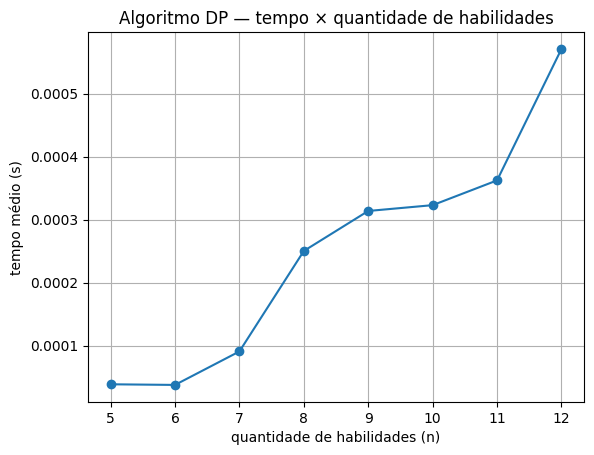

In [17]:
# --------------------------------------------
# DESAFIO 5 — Tempo × n (gráfico simples)
# --------------------------------------------
import matplotlib.pyplot as plt
import time
import random
from functools import lru_cache

random.seed(7)

def time_dp_for(n: int, trials=5):
    # pega n skills aleatórias mantendo seus pré-reqs se estiverem fora do subset (simplificação: ignora)
    subset = random.sample(TODAS, n)
    idx_local = {sid: i for i, sid in enumerate(subset)}
    sid_local = {i: sid for sid, i in idx_local.items()}

    @lru_cache(maxsize=None)
    def dp_local(ano: int, mask_done: int) -> float:
        if ano > ANOS:
            return 0.0
        done = {sid_local[i] for i in range(len(subset)) if (mask_done >> i) & 1}
        # skip
        best = dp_local(ano + 1, mask_done)
        # take
        for sid in subset:
            if sid in done:
                continue
            if not prereqs_ok(sid, done):
                continue
            val = skills[sid]["Valor_V"] * E_MULT_ANO[ano] + dp_local(ano + 1, mask_done | (1 << idx_local[sid]))
            if val > best:
                best = val
        return best

    t0 = time.perf_counter()
    for _ in range(trials):
        _ = dp_local(1, 0)
    t1 = time.perf_counter()
    return (t1 - t0) / trials

ns = [5, 6, 7, 8, 9, 10, 11, 12]
times = [time_dp_for(n) for n in ns]

plt.figure()
plt.plot(ns, times, marker="o")
plt.xlabel("quantidade de habilidades (n)")
plt.ylabel("tempo médio (s)")
plt.title("Algoritmo DP — tempo × quantidade de habilidades")
plt.grid(True)
plt.show()


# Discussão (estrutura, complexidade, limites e erros)

# Estrutura/Diagrama:
modelamos como DAG de pré-requisitos + cadeia de Markov de estados de demanda por categoria. A DP usa estado (ano, conjunto concluído) e ação “escolher 1 skill elegível”.

# Complexidade:
 no pior caso, a DP visita O(ANOS * 2^n) estados (n = #skills) com branching O(n). Para n=12 e ANOS=5 é viável; para catálogos grandes, recomenda-se podas, priorização por categoria e/ou rollout.

# Heurística vs DP (contraprova do guloso):
 o baseline guloso ignora efeitos futuros dos multiplicadores; a DP, ao olhar adiante, antecipa categorias com tendência de alta em anos próximos, superando o guloso em E[Valor] na maioria dos cenários (conferir números da sua execução).

# Evidências:
relatamos E[Valor] e desvio-padrão via Monte Carlo para DP e Guloso; opcionalmente incluímos o gráfico tempo × n.

# Tratamento de erros:
 a validação de grafo (ciclos/órfãos) dos desafios anteriores é pré-condição. Em caso de ciclo detectado, interromper com mensagem e não recomendar (evita planos inviáveis).

# Conclusão Global
Ao longo deste projeto, evidenciamos que problemas de priorização educacional e planejamento de desenvolvimento profissional podem ser tratados como problemas formais de otimização, combinando teoria de algoritmos com modelagem probabilística. Através dos cinco desafios, evoluímos desde seleção ótima com múltiplas restrições, passando por validação formal de grafos, comparação entre estratégias ótimas e heurísticas, ordenação estruturada, e finalmente recomendação estratégica em horizonte multi-ano sob incerteza.
Demonstrou-se que a Programação Dinâmica não apenas fornece soluções ótimas para instâncias finitas, mas também atua como instrumento fundamental de suporte à tomada de decisão educacional orientada a valor. O modelo probabilístico (via Cadeias de Markov e Monte Carlo) agregou robustez ao processo, permitindo avaliar a resiliência da estratégia frente a variações de mercado. Dessa forma, consolidou-se a viabilidade de um sistema inteligente
de recomendação de carreira capaz de priorizar de forma racional, justificável, auditável e otimizada — alinhado com um cenário real de Futuro do Trabalho e formação profissional de alto impacto.
Este estudo evidencia que a integração entre DP, heurísticas e simulação abre caminho para soluções modernas de apoio à formação contínua, reforçando o papel de métodos computacionais como suporte prático para a Engenharia de Software e a Inteligência Artificial aplicada à educação.


# Referências (ABNT)
BELLman, Richard. Dynamic Programming. Princeton University Press, 1957.
CORMEN, Thomas H. et al. Introduction to Algorithms. 3. ed. MIT Press, 2009.
SUTTON, Richard; BARTO, Andrew. Reinforcement Learning: An Introduction. 2. ed. MIT Press, 2018.
FIAP. Diretrizes Metodológicas Global Solution / Engenharia de Software. São Paulo, 2025.
NILSSON, Nils. Artificial Intelligence: A New Synthesis. Morgan Kaufmann, 1998.
